# BGCs analysis

Analyze number of BGCs detected across PATRIC genomes using antiSMASH 

In [1]:
import os
from shutil import copyfile
from Bio import SeqIO
import pandas as pd
from Bio import SeqIO
import networkx as nx

### Common functions

Some common functions used in all the steps of analysis

In [2]:
def get_data_paths(home_dir = '../data/patric_entero/'):
    '''
    Returns a dictionary object with the paths to data used in the notebook
    '''
    
    data_paths = dict(genomes_path = os.path.join(home_dir, 'genomes'),
                      antismash_path = os.path.join(home_dir, 'antismash_out'),
                      bigscape_path = os.path.join(home_dir, 'bigscape'))
    
    return data_paths


def get_pickle_paths(home_dir = '../pickles/'):
    '''
    Returns a dictionary object with the paths to tables used in the notebook
    '''
    
    pickle_paths = dict(strains_path = os.path.join(home_dir, 'df_entero.p'),
                      genus_colors = os.path.join(home_dir, 'genus_colors.p'))
    
                     
    return pickle_paths


def read_metadata(pickle_paths):
    '''
    Reads dataframe about Strains information from PATRIC
    '''
    
    df_genomes = pd.read_pickle(pickle_paths['strains_path'])
    
    genome_ids_list = df_genomes.index.tolist()
    
    return df_genomes, genome_ids_list


data_paths = get_data_paths()
pickle_paths = get_pickle_paths()   

# Read genomes data
df_genomes, genome_ids_list = read_metadata(pickle_paths)
df_genomes

,Genome Name,Organism Name,NCBI Taxon ID,Genome Status,Strain,Serovar,Biovar,Pathovar,MLST,Other Typing,...,Comments,Additional Metadata,Date Inserted,Date Modified,Genus,Genus_cat,max_seq_len,N50_score,N50_by_total,max_by_total
Genome ID,,,,,,,,,,,,,,,,,,,,,
1005057.4,Buchnera aphidicola str. Ua (Uroleucon ambrosiae),Buchnera aphidicola str. Ua (Uroleucon ambrosiae),1005057,Complete,Ua,NaN,NaN,NaN,NaN,NaN,...,DNA was sequenced for the purpose of comparati...,NaN,2014-12-08T22:10:41.211Z,2015-03-16T03:17:09.594Z,Buchnera,Other,615380.0,615380.0,0.979978,0.979978
1005090.4,Buchnera aphidicola str. Ak (Acyrthosiphon kon...,Buchnera aphidicola str. Ak (Acyrthosiphon kon...,1005090,Complete,NaN,NaN,NaN,NaN,NaN,NaN,...,DNA was isolated from an isofemale line of Acy...,NaN,2014-12-08T22:10:41Z,2015-03-16T03:17:09.594Z,Buchnera,Other,641794.0,641794.0,0.982504,0.982504
1006551.4,Klebsiella oxytoca KCTC 1686,Klebsiella oxytoca KCTC 1686,1006551,Complete,KCTC 1686,NaN,NaN,NaN,MLST.Klebsiella_oxytoca.28,NaN,...,Source DNA available from Dr Kap-Seok Yang (k...,NaN,2014-12-08T22:11:48.653Z,2015-03-16T03:17:09.594Z,Klebsiella,Klebsiella,5974109.0,5974109.0,1.000000,1.000000
1006598.5,Serratia plymuthica RVH1,NaN,1006598,Complete,RVH1,NaN,NaN,NaN,NaN,NaN,...,Serratia plymuthica RVH1,NaN,2016-01-17T15:33:35.181Z,2016-01-17T15:33:35.181Z,Serratia,Serratia,5514320.0,5514320.0,1.000000,1.000000
1008297.7,Salmonella enterica subsp. enterica serovar Ty...,Salmonella enterica subsp. enterica serovar Ty...,1008297,Complete,798,serovar Typhimurium,NaN,NaN,NaN,NaN,...,Salmonella enterica var. Typhimurium strain 79...,NaN,2014-12-08T22:12:52.568Z,2015-03-16T03:17:09.594Z,Salmonella,Salmonella,4876219.0,4876219.0,0.981112,0.981112
1009856.3,Buchnera aphidicola str. USDA (Myzus persicae),Buchnera aphidicola str. USDA (Myzus persicae),1009856,Complete,str. USDA (Myzus persicae),NaN,NaN,NaN,NaN,NaN,...,'Buchnera aphidicola str. USDA (Myzus persicae...,NaN,2014-12-08T22:10:41.190Z,2015-03-16T03:17:09.594Z,Buchnera,Other,643504.0,643504.0,0.988021,0.988021
1009857.3,Buchnera aphidicola str. W106 (Myzus persicae),Buchnera aphidicola str. W106 (Myzus persicae),1009857,Complete,str. W106 (Myzus persicae),NaN,NaN,NaN,NaN,NaN,...,'Buchnera aphidicola Mp is the obligate intrac...,NaN,2014-12-08T22:10:41.237Z,2015-03-16T03:17:09.594Z,Buchnera,Other,643502.0,643502.0,0.988021,0.988021
1009858.3,Buchnera aphidicola str. G002 (Myzus persicae),Buchnera aphidicola str. G002 (Myzus persicae),1009858,Complete,str. G002 (Myzus persicae),NaN,NaN,NaN,NaN,NaN,...,'Buchnera aphidicola Mp is the obligate intrac...,NaN,2014-12-08T22:10:41.063Z,2015-03-16T03:17:09.594Z,Buchnera,Other,643517.0,643517.0,0.988026,0.988026
1009859.3,Buchnera aphidicola str. F009 (Myzus persicae),Buchnera aphidicola str. F009 (Myzus persicae),1009859,Complete,str. F009 (Myzus persicae),NaN,NaN,NaN,NaN,NaN,...,'Buchnera aphidicola str. F009 (Myzus persicae...,NaN,2014-12-08T22:10:41.042Z,2015-03-16T03:17:09.594Z,Buchnera,Other,643510.0,643510.0,0.988024,0.988024


### Step 1: Preantismash

696 *E. coli* genomes were downloaded in *.gff* format from ecoref (https://evocellnet.github.io/ecoref/). These were converted to *.fna* format for antiSMASH run with Prokka annotaion provided by *.gff* files. Both files are saved in genomes folder

In [3]:
def fix_accession_ids(data_paths):
    '''
    Updates the accession IDs according to gff file format of PATRIC
    '''
    # This is a temporary fix to get fasta and gff files compatible for antiSMASH run
    # add accc| to all the fasta files so that IDs match with gff
    # The PATRICID_antismash.fasta and PATRICID.PATRIC.gff can be used in antiSMASH run
    
    data_dir = data_paths['genomes_path']
    genome_ids = [f for f in os.listdir(data_dir)]

    for pat_id in genome_ids:
        fasta_file = os.path.join(data_dir, pat_id, pat_id + '.fna')
        anti_fasta_file = os.path.join(data_dir, pat_id, pat_id + '_antismash.fasta')
        with open(fasta_file) as original, open(anti_fasta_file, 'w') as corrected:
            records = SeqIO.parse(original, 'fasta')
            for record in records:          
                record.id = 'accn|' + record.id
                record.description = record.description
                SeqIO.write(record, corrected, 'fasta')

# fix_accession_ids(data_paths)

### Step 2: Run antiSMASH

FASTA and GFF files were used as input for genome mining of BGCs using antiSMASH v4. Output was stored in 'data/patric_entero/antismash_out/'.

### Step 3: Post-antiSMASH

Analyze antiSMASH output and make changes for BiG-SCAPE input

In [4]:
def update_cluster_ids(data_paths, genome_ids_list):
    """
    Updates region file IDs with genome IDs 
    """
    
    antismash_path = data_paths['antismash_path']

    for genome_id in genome_ids_list:
        as4_dir = os.path.join(antismash_path, genome_id)
        if os.path.isdir(as4_dir):
            list_gbk = [f for f in os.listdir(as4_dir) if '.gbk' in f]
            for gbk in list_gbk:
                if 'cluster' in gbk:
                    src = os.path.join(as4_dir, gbk)
                    dest = os.path.join(as4_dir, genome_id + gbk[-15:])
                    os.rename(src, dest)
                elif 'final' in gbk:
                    src = os.path.join(as4_dir, gbk)
                    dest = os.path.join(as4_dir, genome_id + gbk[-10:])
                    os.rename(src, dest)
                    
        else:
            print('No antiSMASH output for', genome_id)
    
    return None        

# update_cluster_ids(data_paths, genome_ids_list)

#### Get clusters information per genome in df_genomes dataframe

In [5]:
def get_cluster_type_counts(data_paths, df_genomes):
    '''
    Add number of clusters of different types in a genome
    '''
    
    antismash_path = data_paths['antismash_path']
    
    for genome_id in df_genomes.index:
        as4_dir = os.path.join(antismash_path, genome_id)
        if os.path.isdir(as4_dir):
            list_clusters = [f for f in os.listdir(as4_dir) if '.gbk' in f and 'cluster' in f]
            
            for cluster_file in list_clusters:
                with open(os.path.join(as4_dir, cluster_file), "r") as handle:
                    for record in SeqIO.parse(handle, "genbank"):
                        for feature in record.features:
                            if feature.type == 'cluster':
                                product = feature.qualifiers['product'][0]
                                
                                if product not in df_genomes.columns:
                                    df_genomes.loc[:, product] = 0
                                
                                df_genomes.loc[genome_id, product] = df_genomes.loc[genome_id, product] + 1
                              
        else:
            print('No antiSMASH output for', genome_id)    
    
    return df_genomes


df_genomes = get_cluster_type_counts(data_paths, df_genomes)

# Make a dataframe of 
df_products = df_genomes.iloc[:,-63:]

#### Get clusters information in df_clusters dataframe

In [15]:
def make_cluster_df(data_paths, df_genomes):
    '''
    Creates a dataframe for storing information on each detected cluster
    '''
    
    antismash_path = data_paths['antismash_path']
    df_clusters = pd.DataFrame(columns=['product', 'contig_edge'])
            
    for genome_id in df_genomes.index:
        as4_dir = os.path.join(antismash_path, genome_id)
        if os.path.isdir(as4_dir):
            list_clusters = [f for f in os.listdir(as4_dir) if '.gbk' in f and 'cluster' in f]
            
            for cluster_file in list_clusters:
                cluster_id = cluster_file[:-4]
                with open(os.path.join(as4_dir, cluster_file), "r") as handle:
                    for record in SeqIO.parse(handle, "genbank"):
                        for feature in record.features:
                            if feature.type == 'cluster':
                                df_clusters.loc[cluster_id, 'product'] = feature.qualifiers['product'][0]
                                df_clusters.loc[cluster_id, 'contig_edge'] = feature.qualifiers['contig_edge'][0]
                                df_clusters.loc[cluster_id, 'Genome ID'] = genome_id
                                df_clusters.loc[
                                    cluster_id, 'Strain Identifier'] = df_genomes.loc[
                                    genome_id, 'Strain Identifier']
                                df_clusters.loc[
                                    cluster_id, 'Phenotype'] = df_genomes.loc[genome_id, 'Phenotype']
                                df_clusters.loc[
                                    cluster_id, 'Genome Name'] = df_genomes.loc[
                                    genome_id, 'Full Strain Name After Genome Analysis']
                                df_clusters.loc[
                                    cluster_id, 'Strain name'] = df_genomes.loc[genome_id, 'Strain name']         
                                
        else:
            print('No antiSMASH output for', genome_id)    
    
    return df_clusters
    

df_clusters = make_cluster_df(data_paths, df_genomes)
df_clusters.head()

KeyError: 'the label [Strain Identifier] is not in the [index]'

### Step 4: Run BiG-SCAPE 

BiG-SCAPE analysis was carried out o
n all detected BGCs with cut-off 0.3, 0.5 and 0.7. As many BGCs are broken, we use 'glocal' alignment mode of BiG-SCAPE. The output was stored in 'data/ecoref_ecoli/bigscape'. 

### Step 5: Post-BiG-SCAPE

BiG-SCAPE generated similarity network was further analyzed for different visualizations. Here, connected components of networks are treated as different families. We do not use finer clustering provided by BiG-SCAPE in to different GCFs (Gene Cluster Families) owing to largely similar genomes in the dataset.

In [323]:
def get_bigscape_paths(data_paths, table_paths, selection_str = 'final'):
    '''
    Expands path dictionaries with BiG-SCAPE generated paths
    
    selection_str : String to be included in the selected run of BiG-SCAPE
    '''
    
    bigscape_path = data_paths['bigscape_path']
    networks_dir = os.path.join(bigscape_path, 'network_files')
    if os.path.isdir(networks_dir):
        network_runs = os.listdir(networks_dir)
        select_run = [run for run in network_runs if 'final' in run][0]
        print(select_run, 'selected from', network_runs)
        node_annot_path = os.path.join(networks_dir, select_run, 'Network_Annotations_Full.tsv')
        data_paths['net_data_path'] = os.path.join(networks_dir, select_run)
        table_paths['node_annot_path'] = node_annot_path
    else:
        print('Bigscape data not found')
    
    return data_paths, table_paths


data_paths, table_paths = get_bigscape_paths(data_paths, table_paths)

2019-11-15_13-17-15_auto_final selected from ['2019-11-15_12-07-45_glocal', '2019-11-15_13-17-15_auto_final']


#### Add BiG-SCAPE related information to df_clusters dataframe

In [324]:
def add_bigscape_class(df_clusters, data_paths, table_paths):
    '''
    Adds BiG-SCAPE cluster classes to detected and generate known clusters
    '''
    
    net_data_path = data_paths['net_data_path'] 
    node_annot_path = table_paths['node_annot_path'] 
    
    df_node_annot = pd.read_table(node_annot_path, sep = '\t', index_col= 'BGC', 
                                  usecols = ['BGC', 'BiG-SCAPE class'])
    
    df_clusters = pd.concat([df_clusters, df_node_annot.reindex(df_clusters.index)], axis=1)
    df_clusters.loc[:, 'bgc_type'] = 'Detected'
    
    return df_clusters


def get_known_clusters(df_clusters, data_paths, table_paths):
    '''
    Returns a separate dataframe of known BGCs
    '''
    
    net_data_path = data_paths['net_data_path'] 
    node_annot_path = table_paths['node_annot_path'] 
    
    df_node_annot = pd.read_table(node_annot_path, sep = '\t', index_col= 'BGC')
    df_known = df_node_annot.loc[[idx for idx in df_node_annot.index if 'BGC0' in idx],:]
    df_known.loc[:, 'bgc_type'] = 'Known'
    for bgc in df_known.index:
        desc = df_known.loc[bgc, 'Description']
        bgc_name = desc.split('biosynthetic gene cluster')[0].strip()
        df_known.loc[bgc, 'Compound Name'] = bgc_name
        
    return df_known

def add_bigscape_families(df_clusters, df_known, data_paths):
    '''
    Adds GCC and GCF numbers detected by BiG-SCAPE clustering for different cut-offs
    '''
    
    net_data_path = data_paths['net_data_path']
    
    cluster_class_set = [cluster_class for cluster_class in os.listdir(net_data_path)
                         if '.tsv' not in cluster_class]
    
    for cluster_class in cluster_class_set:
        class_dir = os.path.join(net_data_path, cluster_class)
        gcf_cutoffs_files = [file for file in os.listdir(class_dir) if '_clustering_' in file]
        for gcf_file in gcf_cutoffs_files:
            cutoff = gcf_file[-8:-4]
            gcf_path = os.path.join(class_dir, gcf_file)
            df_clusters = read_gcf_df(df_clusters, gcf_path, cutoff)
            df_known = read_gcf_df(df_known, gcf_path, cutoff)
            
        clan_files = [file for file in os.listdir(class_dir) if '_clans_' in file]
        if len(clan_files) == 1:
            clan_select = clan_files[0]
            clan_path = os.path.join(class_dir, clan_select)
            
        else:
            print('multiple clan files:', clan_files)
            clan_select = clan_files[0]
            clan_path = os.path.join(class_dir, clan_select)
            print('selected clan file:', clan_select)
        
        df_clusters = read_gcc_df(df_clusters, clan_path)
        df_known = read_gcc_df(df_known, clan_path)
            
    return df_clusters, df_known


def read_gcf_df(df_clusters, gcf_path, cutoff):
    '''
    Adds GCF (Gene Cluster Family) number for each BGC
    '''
        
    df_gcf = pd.read_table(gcf_path, sep = '\t', index_col = '#BGC Name', dtype = str)
    col_name = 'gcf_' + cutoff
    
    for bgc in df_clusters.index:
        if bgc in df_gcf.index:
            df_clusters.loc[bgc, col_name] = df_gcf.loc[bgc, 'Family Number']
            
             
    return df_clusters


def read_gcc_df(df_clusters, clan_path):
    '''
    Adds GCC (Gene Cluster Clan) number for each BGC
    '''
    
    df_gcc = pd.read_table(clan_path, sep = '\t', index_col = '#BGC Name', dtype=str)
    col_name = 'Clan Number'
    
    for bgc in df_clusters.index:
        if bgc in df_gcc.index:
            df_clusters.loc[bgc, col_name] = df_gcc.loc[bgc, 'Clan Number']
            
    return df_clusters
    

df_clusters = add_bigscape_class(df_clusters, data_paths, table_paths)
df_known = get_known_clusters(df_clusters, data_paths, table_paths)
df_clusters, df_known = add_bigscape_families(df_clusters, df_known, data_paths)
df_clusters.head()   
df_known.head()

,Accesion ID,Description,Product Prediction,BiG-SCAPE class,Organism,Taxonomy,bgc_type,Compound Name,gcf_0.30,gcf_0.50,gcf_0.70,Clan Number
BGC,,,,,,,,,,,,
BGC0000001.1,BGC0000001.1,Abyssomicin biosynthetic gene cluster,t1pks,PKSI,Verrucosispora maris AB-18-032,"Bacteria,Actinobacteria,Actinobacteridae,Actin...",Known,Abyssomicin,NaN,NaN,NaN,NaN
BGC0000002.1,BGC0000002.1,Aculeximycin biosynthetic gene cluster,oligosaccharide.t1pks,Others,Kutzneria albida DSM 43870,"Bacteria,Actinobacteria,Actinobacteridae,Actin...",Known,Aculeximycin,NaN,NaN,NaN,NaN
BGC0000003.1,BGC0000003.1,AF-toxin biosynthetic gene cluster,t1pks,PKSI,Alternaria alternata,"Eukaryota,Fungi,Dikarya,Ascomycota,Pezizomycot...",Known,AF-toxin,NaN,NaN,NaN,NaN
BGC0000004.1,BGC0000004.1,Aflatoxin biosynthetic gene cluster,t1pks,PKSI,Aspergillus oryzae,"Eukaryota,Fungi,Dikarya,Ascomycota,Pezizomycot...",Known,Aflatoxin,NaN,NaN,NaN,NaN
BGC0000005.1,BGC0000005.1,Aflatoxin biosynthetic gene cluster,other,Others,Aspergillus parasiticus,"Eukaryota,Fungi,Dikarya,Ascomycota,Pezizomycot...",Known,Aflatoxin,NaN,NaN,NaN,NaN


#### Read and analyze similarity network table 

In [325]:
def get_bigscape_network(data_paths, cutoff = '0.30'):
    '''
    Reads similarity network for a particular to a dataframe
    '''

    net_data_path = data_paths['net_data_path']
    
    cluster_class_set = [cluster_class for cluster_class in os.listdir(net_data_path)
                         if '.tsv' not in cluster_class]
    
    df_network = pd.DataFrame()
    for cluster_class in cluster_class_set:
        class_dir = os.path.join(net_data_path, cluster_class)
        net_file = cluster_class + '_c' + cutoff + '.network'
        net_path = os.path.join(class_dir, net_file)
        df_class_net = pd.read_table(net_path, sep='\t')
        df_network = df_network.append(df_class_net, ignore_index = True)
    
    return df_network


def get_network_graph(df_network, weight = 'Raw distance'):
    '''
    Returns networkX graph for a given network
    '''
    
    G_clusters = nx.from_pandas_edgelist(df_network, 'Clustername 1', 'Clustername 2', weight)
    G_families = nx.connected_components(G_clusters)
    family_nodes = [c for c in sorted(G_families, key=len, reverse=True)]
    
    return G_clusters, family_nodes
    
    
def remove_single_mibig(df_network, family_nodes):
    '''
    Removes singleton MIBIG BGCs from the network
    '''
    
    nodes_to_remove = []
    
    for fam in family_nodes:
        single_mibig = True
        
        for node in fam:
            if 'BGC' not in node:
                single_mibig = False
        
        if single_mibig:
            for node in fam:
                if node not in nodes_to_remove:
                    nodes_to_remove.append(node)
                
    df_network = df_network[~df_network['Clustername 1'].isin(nodes_to_remove)]
    df_network = df_network[~df_network['Clustername 2'].isin(nodes_to_remove)]
                        
    return df_network
  
    
df_network = get_bigscape_network(data_paths, cutoff = '0.30')
G_clusters, family_nodes = get_network_graph(df_network, weight = 'Raw distance')
df_network = remove_single_mibig(df_network, family_nodes)
G_clusters, family_nodes = get_network_graph(df_network, weight = 'Raw distance')

#### Update df_clusters with family numbers (connected components)

In [326]:
def update_cluster_family(df_clusters, df_known, family_nodes, cutoff = '0.30'):
    '''
    Updates df_clusters with family ids (connected components)
    '''
    
    for cntr in range(len(family_nodes)):
        fam_id = cntr + 1
        family = family_nodes[cntr]
        
        known_bgcs = [bgc for bgc in family if bgc in df_known.index]
        
        for bgc in family:
            if bgc in df_clusters.index:
                df_clusters.loc[bgc, 'fam_id'] = str(fam_id)
                bgc_class = df_clusters.loc[bgc, 'BiG-SCAPE class']
                if len(known_bgcs) > 0:
                    df_clusters.loc[bgc, 'fam_type'] = 'known_family'
                    known_compounds = ', '.join(df_known.loc[known_bgcs, 'Compound Name'].tolist())
                    df_clusters.loc[bgc, 'fam_known_compounds'] = known_compounds
                else:
                    df_clusters.loc[bgc, 'fam_type'] = 'unknown_family'
                    df_clusters.loc[bgc, 'fam_known_compounds'] = 'u_' + bgc_class + '_' + str(fam_id)
                    
                    
            elif bgc in df_known.index:
                df_known.loc[bgc, 'fam_id'] = str(fam_id)
                
    return df_clusters, df_known
    

def drop_ignored_clusters(df_clusters):
    '''
    Drops the rows if clusters are ignored from BiG-SCAPE analysis
    '''
    
    df_clusters.dropna(subset=['fam_id'], inplace=True)
    
    return df_clusters
    

df_clusters, df_known = update_cluster_family(df_clusters, df_known, family_nodes, 
                                              cutoff = '0.30')    
df_clusters = drop_ignored_clusters(df_clusters)

In [327]:
df_clusters.columns

Index(['product', 'contig_edge', 'Genome ID', 'Strain Identifier', 'Phenotype',
       'Genome Name', 'Strain name', 'BiG-SCAPE class', 'bgc_type', 'gcf_0.30',
       'gcf_0.50', 'gcf_0.70', 'Clan Number', 'fam_id', 'fam_type',
       'fam_known_compounds'],
      dtype='object')

#### Manually fix NRPS cluster to be Enterobactin

In [328]:
def add_enterobactin_manually(df_clusters):
    '''
    Enterobactin cluster was not associated with MIBIG cluster as there was no Enterobactin entry and thus was added manually
    '''
    
    df_clusters.loc[df_clusters['fam_id'] == '1', 'fam_type'] = 'known_family'
    df_clusters.loc[df_clusters['fam_id'] == '1', 'fam_known_compounds'] = 'Enterobactin'
    
    return df_clusters


df_clusters = add_enterobactin_manually(df_clusters)

### Step 6: Analysis of genomes with different BGC families

In [329]:
def get_family_columns(df_genomes, df_clusters):
    '''
    Expand columns of df_genomes to include family IDs
    '''
    
    fam_ids_dict = dict(zip(df_clusters['fam_id'], df_clusters['fam_known_compounds']))
    for cntr in range(len(fam_ids_dict)):
        fam_id = str(cntr + 1)
        col_id = fam_ids_dict[fam_id]
        
        df_genomes.loc[:, col_id] = 0
    
    return df_genomes


def get_family_genome_dist(df_genomes, df_clusters):
    '''
    Adds BGC family information to df_genomes
    '''
    
    for bgc in df_clusters.index:
        col_id = df_clusters.loc[bgc, 'fam_known_compounds']
        
        genome_id = df_clusters.loc[bgc, 'Genome ID']
        
        df_genomes.loc[genome_id, col_id] = df_genomes.loc[genome_id, col_id] + 1
    
    return df_genomes

df_genomes = get_family_columns(df_genomes, df_clusters)
df_genomes = get_family_genome_dist(df_genomes, df_clusters)

In [330]:
df_genomes

,Strain Identifier,Strain name,Evolution Experiment?,Parental Strain,Alternative Strain Name,Full Strain Name After Genome Analysis,ENA Accession,Alternative Genome Source,Reference (PMID),Isolation origin,...,u_Others_25,u_Others_26,u_PKS-NRP_Hybrids_27,u_RiPPs_28,u_RiPPs_29,u_RiPPs_30,u_RiPPs_31,u_RiPPs_32,u_RiPPs_33,u_RiPPs_34
Genome ID,,,,,,,,,,,,,,,,,,,,,
NT12001_189,NT12001,MG1655,0,NaN,NaN,Escherichia coli str. K-12 substr. MG1655,PRJNA57779,NaN,22081388;16738553;16397293;9278503,"Diphtheria patient in Palo Alto, CA, USA",...,0,0,0,0,0,0,0,0,0,0
NT12002_188,NT12002,MC4100,0,NaN,NaN,Escherichia coli str. K-12 substr. MC4100,PRJEB4621,NaN,781293,Derivation of K-12,...,0,0,0,0,0,0,0,0,0,0
NT12003_214,NT12003,W3110,0,NaN,NaN,Escherichia coli W3110,PRJEB20550,NaN,4568763,Derivation of K-12,...,0,0,0,0,0,0,0,0,0,0
NT12004_22,NT12004,BW25113,0,NaN,NaN,Escherichia coli BW25113,PRJNA257976,NaN,10829079,Derivation of K-12,...,0,0,0,0,0,0,0,0,0,0
NT12005_17,NT12005,BL21(DE3),0,NaN,NaN,Escherichia coli BL21(DE3),PRJEA161949,NaN,19786035,Probable commensal isolate from Institut Pasteur,...,0,0,0,0,0,0,0,0,0,0
NT12006_215,NT12006,DH5a,0,NaN,NaN,Escherichia coli DH5a,PRJEB20550,NaN,NaN,Derivation of K-12,...,0,0,0,0,0,0,0,0,0,0
NT12007_60,NT12007,ED1a,0,NaN,NaN,Escherichia coli ED1a,PRJNA59379,NaN,19165319,Human feces,...,0,0,0,0,0,0,0,0,0,0
NT12010_146,NT12010,Nissle 1917,0,NaN,NaN,Escherichia coli Nissle 1917,PRJNA186643,NaN,NaN,"Commensal isolate from Freiburg, Germany",...,0,0,0,0,0,0,0,0,0,0
NT12011_132,NT12011,MP1,0,NaN,NaN,Escherichia coli MP1,PRJNA196008,NaN,24563035,Mouse feces,...,0,0,0,0,0,0,0,0,0,0


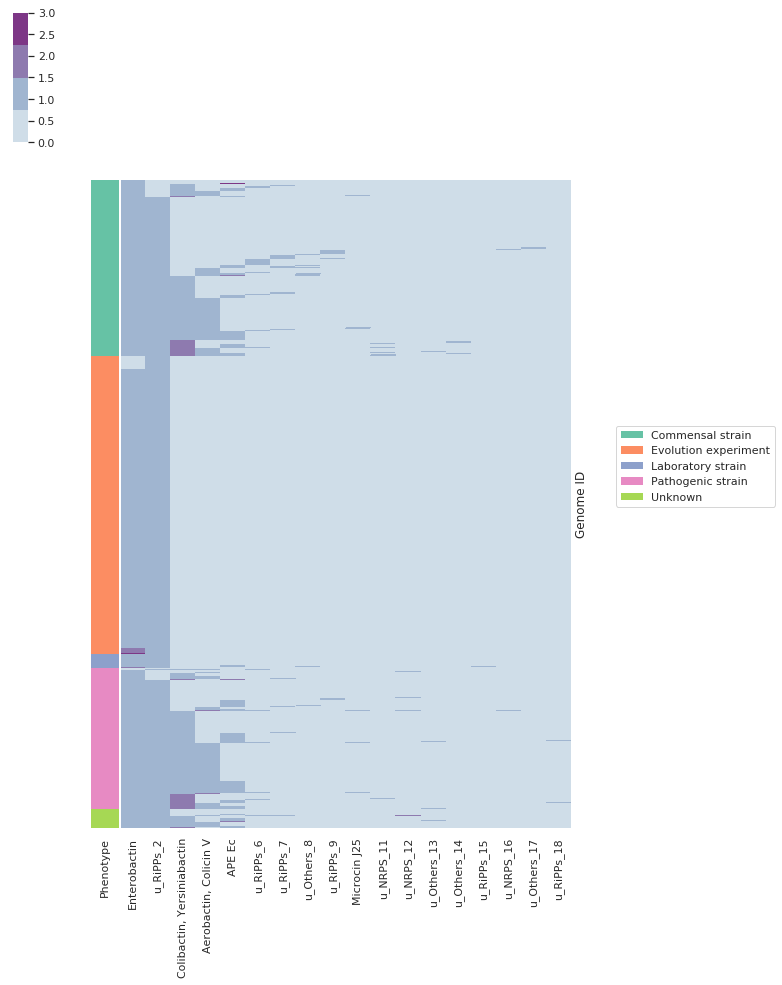

In [331]:
def plot_fam_genomes(df_genomes, save_fig_path):
    import seaborn as sns; sns.set(color_codes=True)
    import matplotlib.pyplot as plt

    sns.set_style('white')
    sort_by = ['Phenotype'] + df_genomes.columns[30:48].tolist()

    df_genomes.sort_values(by= sort_by, inplace=True)
    phenotype = df_genomes["Phenotype"]

    lut1 = dict(zip(phenotype.unique(), sns.color_palette("Set2", n_colors=6, desat=1)))
    row_colors = phenotype.map(lut1)

    xticklabels=df_genomes.columns[30:48].tolist()

    # Signleton families are ignored (19 to 34)
    g = sns.clustermap(df_genomes.iloc[:,30:48], row_colors=row_colors, row_cluster = False, col_cluster= False, 
                       cmap=sns.color_palette("BuPu", n_colors=4, desat=0.8), yticklabels=False, 
                       xticklabels=xticklabels, figsize=(10,15))

    for label in lut1:
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label],
                                label=label, linewidth=0)
    g.ax_col_dendrogram.legend(loc=(1.1,-2), ncol=1)

    plt.savefig(save_fig_path, bbox_inches='tight', pad_inches=0.2)
    plt.show()
    
    
save_fig_path = '../figures/raw/ecoref_genomes_family.png'    
plot_fam_genomes(df_genomes, save_fig_path)

In [332]:
df_genomes.to_csv('/data/a/pansecmet/tables/ecoref_ecoli/ecoref_genomes.csv')
df_clusters.to_csv('/data/a/pansecmet/tables/ecoref_ecoli/ecoref_clusters.csv')
df_known.to_csv('/data/a/pansecmet/tables/ecoref_ecoli/known_bgcs.csv')